# **PREDICCIÓN DEL PRECIO DEL BITCOIN CON DEEP LEARNING Y ESQUEMA DE INVERSIÓN SIMULADO**


# **APROXIMACIÓN 1. LSTM con Log Price y Rezagos**

In [ ]:
# Importamos librerías necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import product
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [ ]:
# Cargamos información BTC/USD

df=pd.read_excel('/content/BitCoin_2016_202403_A.xlsx')

In [ ]:
# Validamos base

df

,Date,Price,Open,High,Low,Vol.,Change %
0,03/31/2024,71332.0,69608.5,71367.5,69576.6,4245000.0,2.47
1,03/30/2024,69611.5,69872.3,70321.2,69564.9,2987000.0,-0.37
2,03/29/2024,69871.7,70766.7,70907.0,69090.9,5899000.0,-1.26
3,03/28/2024,70762.1,69449.4,71542.5,68956.9,7249000.0,1.90
4,03/27/2024,69442.4,69999.2,71670.8,68428.6,11288000.0,-0.80
...,...,...,...,...,...,...,...
3008,01/05/2016,431.2,433.3,435.3,428.9,4503000.0,-0.49
3009,01/04/2016,433.3,430.7,435.3,428.6,5301000.0,0.61
3010,01/03/2016,430.7,433.7,434.1,423.1,5483000.0,-0.70
3011,01/02/2016,433.7,434.0,437.4,430.7,3357000.0,-0.06


In [ ]:
# Transformamos formato de 'Date'

df['Date']=pd.to_datetime(df['Date'])

In [ ]:
# Ponemos fecha como Index

df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

In [ ]:
# Validamos df

df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2016-01-01,434.0,430.0,438.0,425.9,4697000.0,0.94
2016-01-02,433.7,434.0,437.4,430.7,3357000.0,-0.06
2016-01-03,430.7,433.7,434.1,423.1,5483000.0,-0.70
2016-01-04,433.3,430.7,435.3,428.6,5301000.0,0.61
2016-01-05,431.2,433.3,435.3,428.9,4503000.0,-0.49
...,...,...,...,...,...,...
2024-03-27,69442.4,69999.2,71670.8,68428.6,11288000.0,-0.80
2024-03-28,70762.1,69449.4,71542.5,68956.9,7249000.0,1.90
2024-03-29,69871.7,70766.7,70907.0,69090.9,5899000.0,-1.26


In [ ]:
# Validamos Tipos de Datos

df.dtypes

Price       float64
Open        float64
High        float64
Low         float64
Vol.        float64
Change %    float64
dtype: object

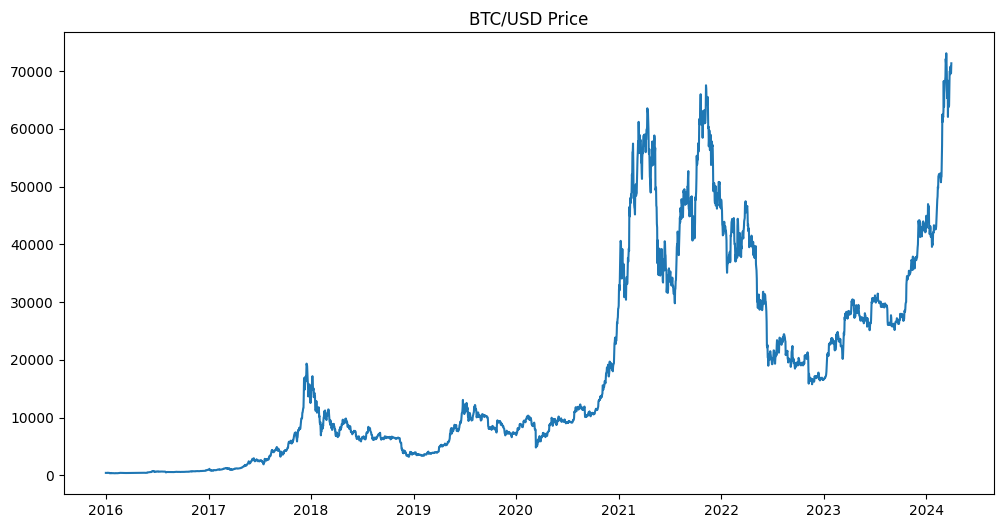

In [ ]:
# Graficamos Precio contra Tiempo

plt.figure(figsize=(12, 6))
plt.plot(df['Price'])
plt.title('BTC/USD Price')
plt.show()

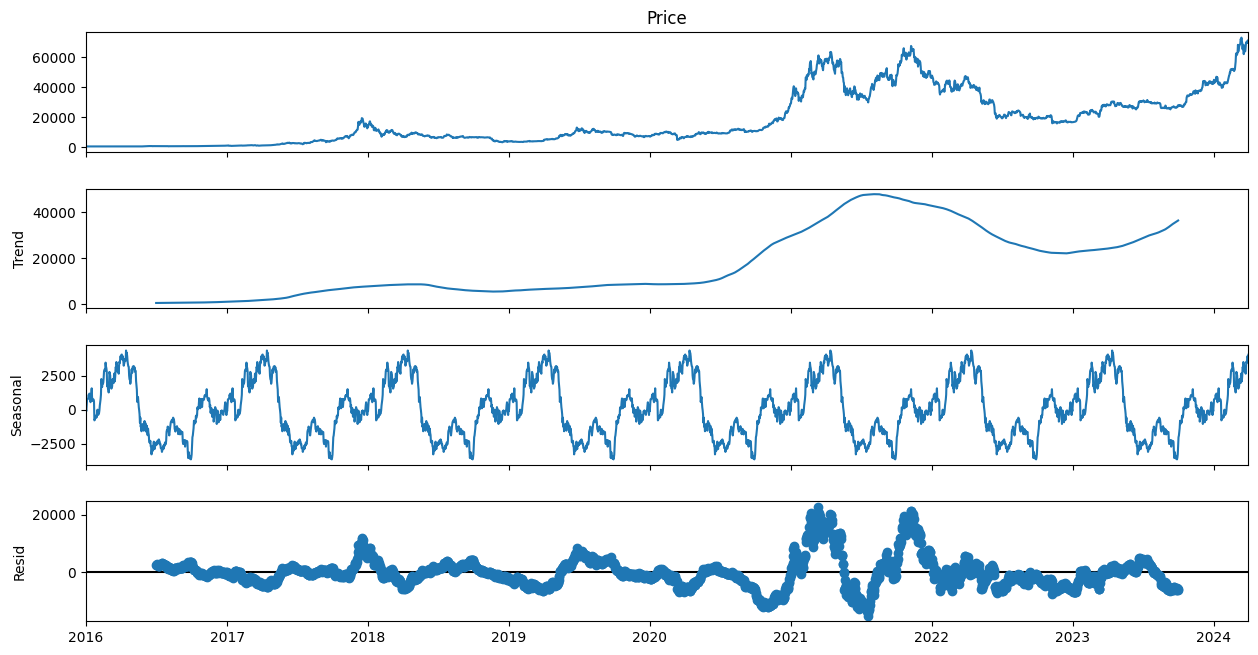

In [ ]:
# Descomponemos en patrones cíclicos

decomposition = seasonal_decompose(df['Price'], model='additive', period=365)
fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()

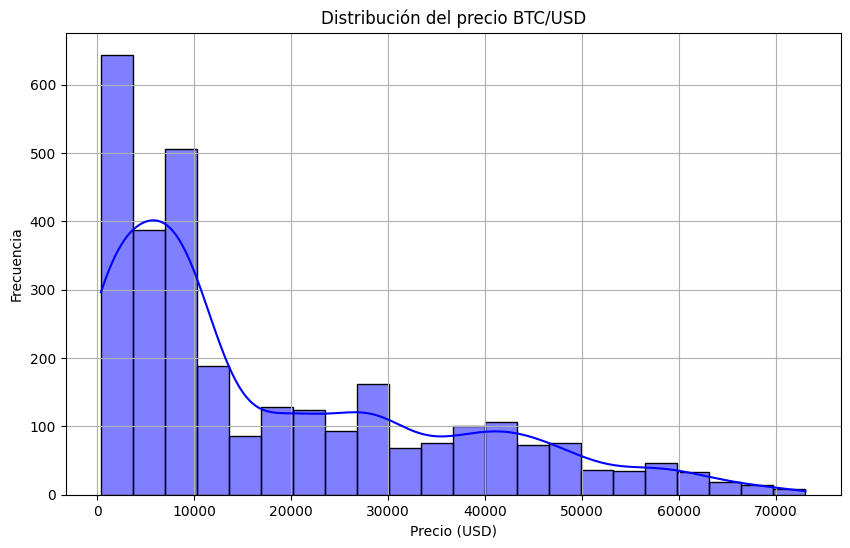

In [ ]:
# Graficamos Distribución de la Serie en Log BTC/USD

plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True, color='b')
plt.title('Distribución del precio BTC/USD')
plt.xlabel('Precio (USD)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [ ]:
# Implementamos transformación logarítmica

df['Log_Price']=np.log(df['Price'])

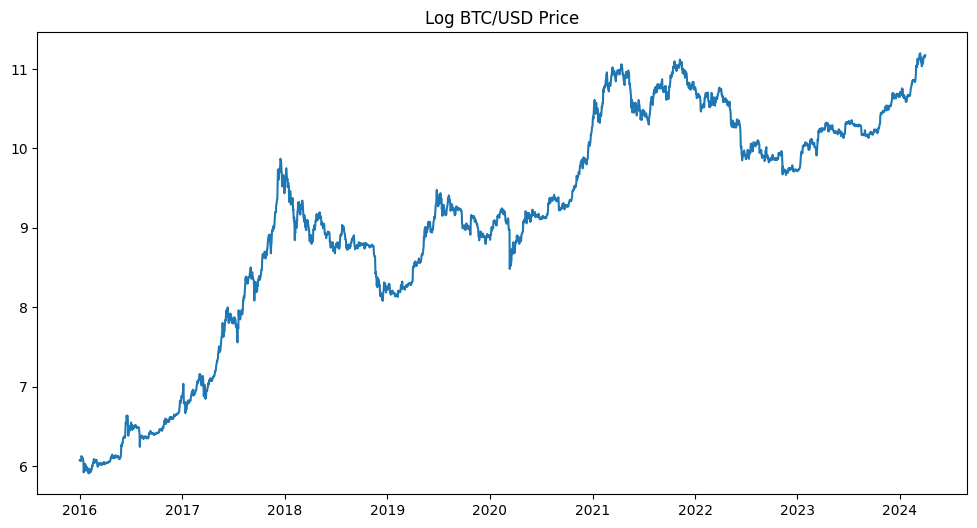

In [ ]:
# Graficamos serie transformada

plt.figure(figsize=(12, 6))
plt.plot(df['Log_Price'])
plt.title('Log BTC/USD Price')
plt.show()

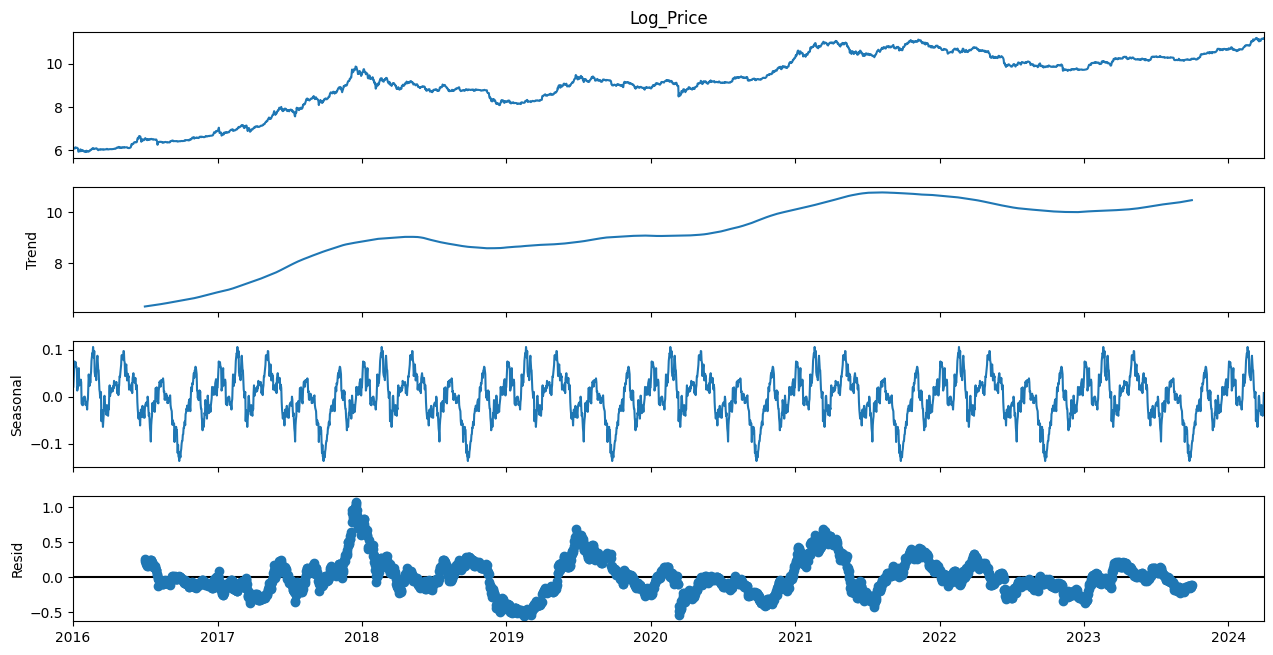

In [ ]:
# Desagregamos componentes

decomposition = seasonal_decompose(df['Log_Price'], model='additive', period=365)
fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()

In [ ]:
# Creamos rezagos

def create_lag_features(data, n_lags=2):
    lagged_data = data.copy()
    for lag in range(1, n_lags + 1):
        lagged_data[f'log_lag_{lag}'] = lagged_data['Log_Price'].shift(lag)
    return lagged_data

lagged_df = create_lag_features(df, n_lags=4) # Incrementamos Lags
lagged_df.dropna(inplace=True)  # Quitamos NaN

In [ ]:
# Dividimos en entrenamiento y test

split_date = lagged_df.index[int(0.8 * len(lagged_df))]
train_df = lagged_df[lagged_df.index < split_date]
test_df = lagged_df[lagged_df.index >= split_date]

X_train = train_df.drop(columns=['Price','Log_Price'])
y_train = train_df['Log_Price']
X_test = test_df.drop(columns=['Price','Log_Price'])
y_test = test_df['Log_Price']

In [ ]:
# Validamos conjuntos sobre órden Cronológico

X_train

,Open,High,Low,Vol.,Change %,log_lag_1,log_lag_2,log_lag_3,log_lag_4
Date,,,,,,,,,
2016-01-05,433.3,435.3,428.9,4503000.0,-0.49,6.071430,6.065412,6.072353,6.073045
2016-01-06,431.2,432.1,425.0,4343000.0,-0.09,6.066572,6.071430,6.065412,6.072353
2016-01-07,430.8,457.5,428.5,13020000.0,6.09,6.065644,6.066572,6.071430,6.065412
2016-01-08,457.0,462.9,446.5,9131000.0,-0.91,6.124683,6.065644,6.066572,6.071430
2016-01-09,452.9,454.5,444.9,3981000.0,-1.01,6.115671,6.124683,6.065644,6.066572
...,...,...,...,...,...,...,...,...,...
2022-08-03,22988.7,23623.7,22698.6,17466000.0,-0.73,10.042754,10.054972,10.056355,10.070450
2022-08-04,22822.2,23214.5,22438.7,18119000.0,-0.91,10.035428,10.042754,10.054972,10.056355
2022-08-05,22613.3,23447.6,22593.5,20890000.0,3.08,10.026240,10.035428,10.042754,10.054972


In [ ]:
X_test

,Open,High,Low,Vol.,Change %,log_lag_1,log_lag_2,log_lag_3,log_lag_4
Date,,,,,,,,,
2022-08-08,23175.3,24234.1,23160.6,19794000.0,2.77,10.050842,10.040820,10.056561,10.026240
2022-08-09,23818.1,23912.0,22886.5,16962000.0,-2.81,10.078125,10.050842,10.040820,10.056561
2022-08-10,23150.3,24209.9,22714.7,24361000.0,3.53,10.049608,10.078125,10.050842,10.040820
2022-08-11,23963.3,24873.5,23864.0,28536000.0,-0.12,10.084262,10.049608,10.078125,10.050842
2022-08-12,23935.3,24440.8,23616.4,19496000.0,1.94,10.083110,10.084262,10.049608,10.078125
...,...,...,...,...,...,...,...,...,...
2024-03-27,69999.2,71670.8,68428.6,11288000.0,-0.80,11.156241,11.154706,11.115606,11.067229
2024-03-28,69449.4,71542.5,68956.9,7249000.0,1.90,11.148253,11.156241,11.154706,11.115606
2024-03-29,70766.7,70907.0,69090.9,5899000.0,-1.26,11.167079,11.148253,11.156241,11.154706


In [ ]:
# Escalamos Datos

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [ ]:
# Creamos Modelo

def create_model(optimizer='adam', units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
# Redimensionamos para LSTM

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

In [ ]:
# Establecemos Hiper-Parámetros Grid

param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'optimizer': ['adam', 'rmsprop'],
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3]
}

In [ ]:
# Realizamos partición para serie de Tiempo y Cross Validation

tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
# Generamos Grid Seach

best_score = float('inf')
best_params = {}
for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for optimizer in param_grid['optimizer']:
            for units in param_grid['units']:
                for dropout_rate in param_grid['dropout_rate']:
                    for train_index, val_index in tscv.split(X_train_reshaped):
                        X_train_fold, X_val_fold = X_train_reshaped[train_index], X_train_reshaped[val_index]
                        y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]

                        model = create_model(optimizer=optimizer, units=units, dropout_rate=dropout_rate)
                        model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=0)

                        y_val_pred = model.predict(X_val_fold)
                        score = mean_squared_error(y_val_fold, y_val_pred)

                        if score < best_score:
                            best_score = score
                            best_params = {
                                'batch_size': batch_size,
                                'epochs': epochs,
                                'optimizer': optimizer,
                                'units': units,
                                'dropout_rate': dropout_rate
                            }

# Mostramos mejores resultados y puntaje

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

19/19 [==============================] - 1s 2ms/step
Best parameters: {'batch_size': 16, 'epochs': 20, 'optimizer': 'rmsprop', 'units': 100, 'dropout_rate': 0.2}
Best score: 0.005491392826606273


In [ ]:
# Entrenamos mejor modelo sobre el conjunto de entrenamiento

best_model = create_model(optimizer=best_params['optimizer'], units=best_params['units'], dropout_rate=best_params['dropout_rate'])
best_model.fit(X_train_reshaped, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)


In [ ]:
# Evaluamos modelo en conjunto test

y_pred = best_model.predict(X_test_reshaped)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

19/19 [==============================] - 1s 2ms/step
Test RMSE: 0.09158311002906647


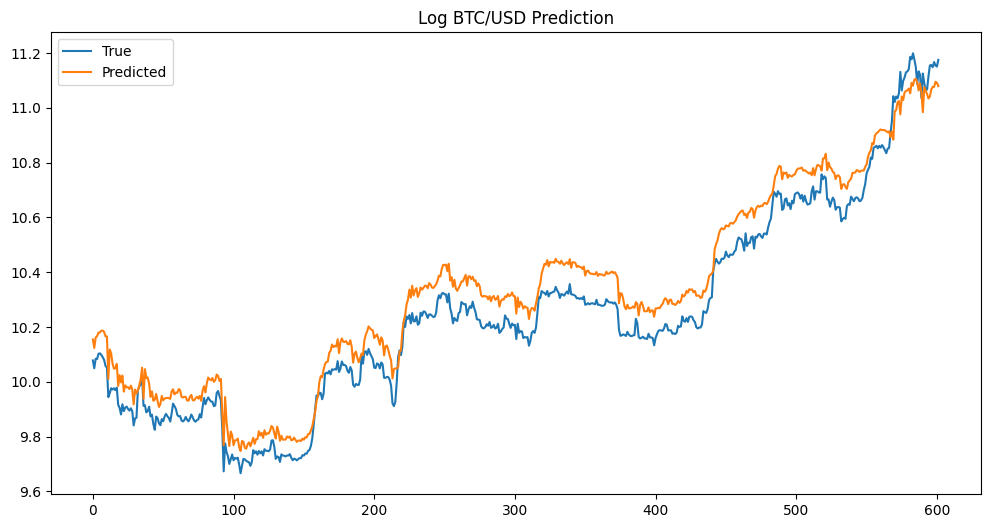

In [ ]:
# Graficamos predicciones contra valores reales

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('Log BTC/USD Prediction')
plt.legend()
plt.show()

In [ ]:
# Incorporamos Esquema de Inversión para ver Efecto de la Predicción en Objetivo de Negocio

# Convertimos log_price en niveles originales

y_test = y_test.ravel()
y_pred = y_pred.ravel()

mean = scaler.mean_[0]
scale = scaler.scale_[0]

y_test_prices = y_test * scale + mean
y_pred_prices = y_pred * scale + mean


# Calculamos cambios en precios predichos

price_changes = y_pred_prices[1:] - y_test_prices[:-1]

print("Dimensiones Price changes:", price_changes.shape)
print("Dimensión y_test_prices:", y_test_prices.shape)


# Generamos Señales de compra/venta

signals = np.where(price_changes > 0, 1, np.where(price_changes < 0, -1, 0))


# Validamos Dimensiones

print("Dimensión Signals:", signals.shape)
print("Muestra Signals:", signals[:10])


# Calculamos Retornos

initial_capital = 10000
capital = initial_capital
position = 0
for i, (signal, price) in enumerate(zip(signals, y_test_prices[1:])):
    if isinstance(signal, np.ndarray):
        signal = signal[0]  # Ensure signal is a scalar
    if signal == 1:  # Buy
        if capital > 0:
            position = capital / price
            capital = 0
    elif signal == -1:  # Sell
        if position > 0:
            capital = position * price
            position = 0
    print(f"Iteration {i}, Signal: {signal}, Price: {price}, Capital: {capital}, Position: {position}")

Dimensiones Price changes: (601,)
Dimensión y_test_prices: (602,)
Dimensión Signals: (601,)
Muestra Signals: [1 1 1 1 1 1 1 1 1 1]
Iteration 0, Signal: 1, Price: 186381.0624278266, Capital: 0, Position: 0.05365351967489914
Iteration 1, Signal: 1, Price: 186972.2585876067, Capital: 0, Position: 0.05365351967489914
Iteration 2, Signal: 1, Price: 186952.59825289506, Capital: 0, Position: 0.05365351967489914
Iteration 3, Signal: 1, Price: 187279.72614043008, Capital: 0, Position: 0.05365351967489914
Iteration 4, Signal: 1, Price: 187310.32384671364, Capital: 0, Position: 0.05365351967489914
Iteration 5, Signal: 1, Price: 187212.54029273585, Capital: 0, Position: 0.05365351967489914
Iteration 6, Signal: 1, Price: 187070.78809492747, Capital: 0, Position: 0.05365351967489914
Iteration 7, Signal: 1, Price: 186896.55608800813, Capital: 0, Position: 0.05365351967489914
Iteration 8, Signal: 1, Price: 186521.47576444218, Capital: 0, Position: 0.05365351967489914
Iteration 9, Signal: 1, Price: 186

In [ ]:
# Capital Final

if position > 0:
    capital = position * y_test_prices[-1]

print(f"Capital Inicial : ${initial_capital}")
print(f"Capital Final: ${capital:.2f}")

Capital Inicial : $10000
Capital Final: $10887.37


# **APROXIMACIÓN 2. LSTM con Log Price, rezagos y componentes cíclicos**

In [ ]:
# Importamos librerías necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [ ]:
# Cargamos información BTC/USD

df=pd.read_excel('/content/BitCoin_2016_202403_A.xlsx')

In [ ]:
# Ajustamos formato de 'Date'

df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# Establecemos 'Date' como index y aseguramos órden cronológico

df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

In [ ]:
# Implementamos transformación logarítmica

df['Log_Price'] = np.log(df['Price'])

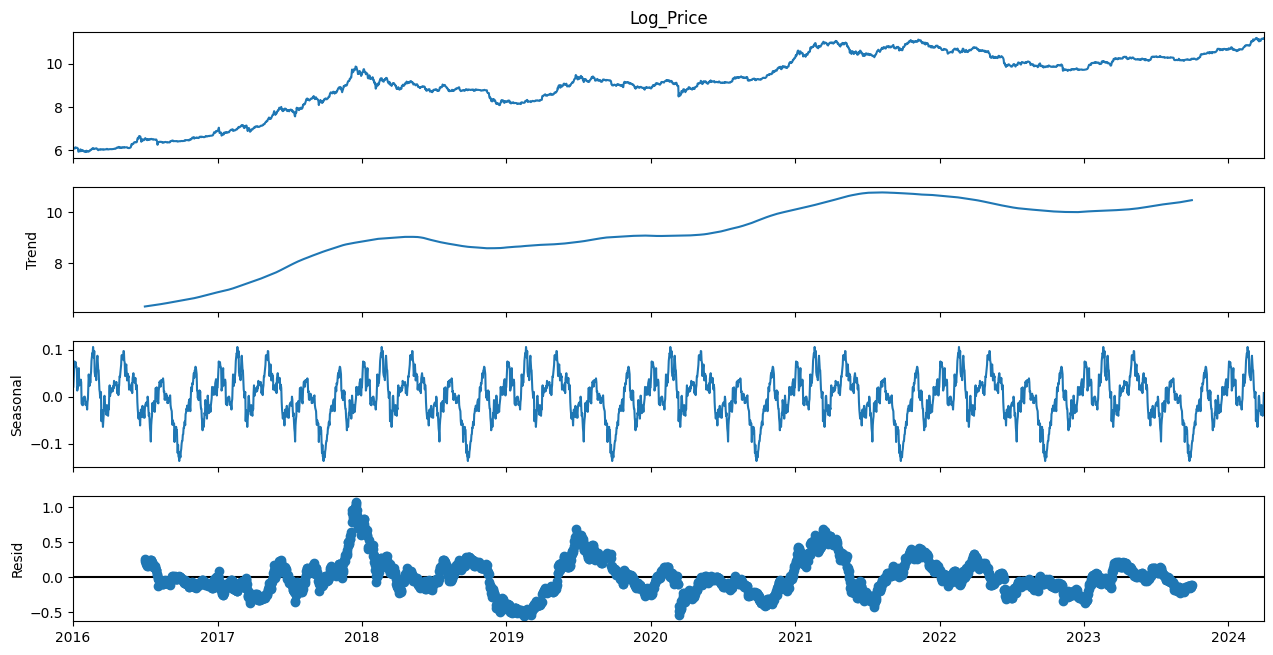

In [ ]:
# Desagregamos componentes

decomposition = seasonal_decompose(df['Log_Price'], model='additive', period=365)
df['Seasonal'] = decomposition.seasonal
fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()

In [ ]:
# Creamos rezagos con componentes cíclicos

def create_lag_features(data, n_lags=30):
    lagged_data = data.copy()
    for lag in range(1, n_lags + 1):
        lagged_data[f'log_lag_{lag}'] = lagged_data['Log_Price'].shift(lag)
    lagged_data['Seasonal'] = data['Seasonal']  # Incluimos componentes estacionales
    return lagged_data


lagged_df = create_lag_features(df, n_lags=4) # Incrementamos número de rezagos
lagged_df.dropna(inplace=True)  # Quitamos Valores NaN

In [ ]:
# Particionamos en train y test de forma cronológica

split_date = lagged_df.index[int(0.8 * len(lagged_df))]
train_df = lagged_df[lagged_df.index < split_date]
test_df = lagged_df[lagged_df.index >= split_date]

X_train = train_df.drop(columns=['Price', 'Log_Price'])
y_train = train_df['Log_Price']
X_test = test_df.drop(columns=['Price', 'Log_Price'])
y_test = test_df['Log_Price']

In [ ]:
X_train

,Open,High,Low,Vol.,Change %,Seasonal,log_lag_1,log_lag_2,log_lag_3,log_lag_4
Date,,,,,,,,,,
2016-01-05,433.3,435.3,428.9,4503000.0,-0.49,0.075069,6.071430,6.065412,6.072353,6.073045
2016-01-06,431.2,432.1,425.0,4343000.0,-0.09,0.064522,6.066572,6.071430,6.065412,6.072353
2016-01-07,430.8,457.5,428.5,13020000.0,6.09,0.065053,6.065644,6.066572,6.071430,6.065412
2016-01-08,457.0,462.9,446.5,9131000.0,-0.91,0.073638,6.124683,6.065644,6.066572,6.071430
2016-01-09,452.9,454.5,444.9,3981000.0,-1.01,0.065053,6.115671,6.124683,6.065644,6.066572
...,...,...,...,...,...,...,...,...,...,...
2022-08-03,22988.7,23623.7,22698.6,17466000.0,-0.73,-0.014351,10.042754,10.054972,10.056355,10.070450
2022-08-04,22822.2,23214.5,22438.7,18119000.0,-0.91,0.012511,10.035428,10.042754,10.054972,10.056355
2022-08-05,22613.3,23447.6,22593.5,20890000.0,3.08,0.020294,10.026240,10.035428,10.042754,10.054972


In [ ]:
# Escalamos datos

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Función para crear Modelo

def create_model(optimizer='adam', units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
# Adaptamos dimensiones para LSTM

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

In [ ]:
# Establecemos Grid para Hiperparámetros

param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'optimizer': ['adam', 'rmsprop'],
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3]
}

In [ ]:
# Dividimos Serie para Cross Validation

tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
# Implementamos Grid Search

best_score = float('inf')
best_params = {}
for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for optimizer in param_grid['optimizer']:
            for units in param_grid['units']:
                for dropout_rate in param_grid['dropout_rate']:
                    for train_index, val_index in tscv.split(X_train_reshaped):
                        X_train_fold, X_val_fold = X_train_reshaped[train_index], X_train_reshaped[val_index]
                        y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]

                        model = create_model(optimizer=optimizer, units=units, dropout_rate=dropout_rate)
                        model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=0)

                        y_val_pred = model.predict(X_val_fold)
                        score = mean_squared_error(y_val_fold, y_val_pred)

                        if score < best_score:
                            best_score = score
                            best_params = {
                                'batch_size': batch_size,
                                'epochs': epochs,
                                'optimizer': optimizer,
                                'units': units,
                                'dropout_rate': dropout_rate
                            }

# Mostramos mejores parámetros y puntaje
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")


19/19 [==============================] - 1s 3ms/step
Best parameters: {'batch_size': 16, 'epochs': 20, 'optimizer': 'rmsprop', 'units': 100, 'dropout_rate': 0.3}
Best score: 0.008394773652032004


In [ ]:
# Entrenamos mejor modelo sobre conjunto de entrenamiento total

best_model = create_model(optimizer=best_params['optimizer'], units=best_params['units'], dropout_rate=best_params['dropout_rate'])
best_model.fit(X_train_reshaped, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [ ]:
# Evaluamos modelo en test

y_pred = best_model.predict(X_test_reshaped)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

19/19 [==============================] - 1s 3ms/step
Test RMSE: 0.1918820802680258


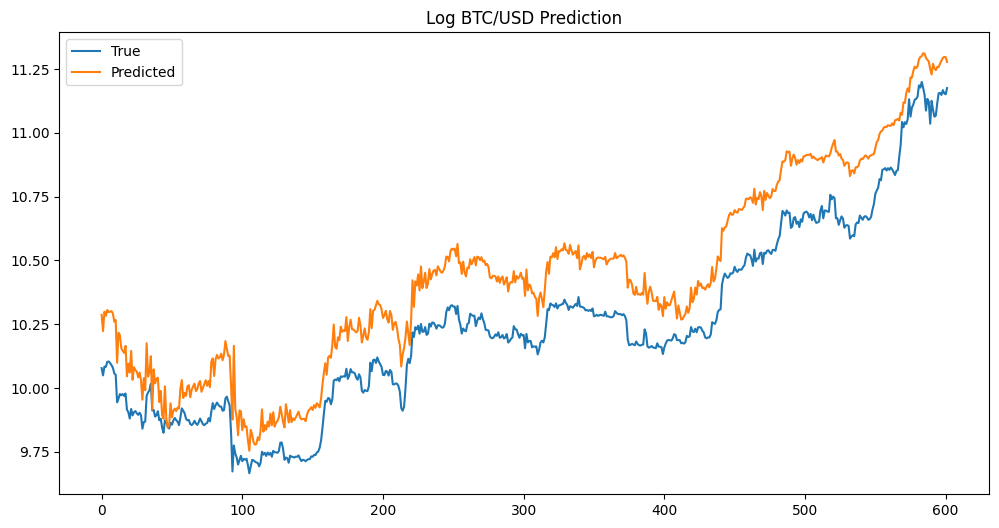

In [ ]:
# Graficamos predicciones contra valores reales

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('Log BTC/USD Prediction')
plt.legend()
plt.show()

In [ ]:
# Incorporamos Esquema de Inversión para ver Efecto de la Predicción en Objetivo de Negocio

# Convertimos log_price en niveles originales

y_test = y_test.ravel()
y_pred = y_pred.ravel()

mean = scaler.mean_[0]
scale = scaler.scale_[0]

y_test_prices = y_test * scale + mean
y_pred_prices = y_pred * scale + mean


# Calculamos cambios en precios predichos

price_changes = y_pred_prices[1:] - y_test_prices[:-1]

print("Dimensiones Price changes:", price_changes.shape)
print("Dimensión y_test_prices:", y_test_prices.shape)


# Generamos Señales de compra/venta

signals = np.where(price_changes > 0, 1, np.where(price_changes < 0, -1, 0))


# Validamos Dimensiones

print("Dimensión Signals:", signals.shape)
print("Muestra Signals:", signals[:10])


# Calculamos Retornos

initial_capital = 10000
capital = initial_capital
position = 0
for i, (signal, price) in enumerate(zip(signals, y_test_prices[1:])):
    if isinstance(signal, np.ndarray):
        signal = signal[0]  # Ensure signal is a scalar
    if signal == 1:  # Buy
        if capital > 0:
            position = capital / price
            capital = 0
    elif signal == -1:  # Sell
        if position > 0:
            capital = position * price
            position = 0
    print(f"Iteration {i}, Signal: {signal}, Price: {price}, Capital: {capital}, Position: {position}")

# Capital Final

if position > 0:
    capital = position * y_test_prices[-1]

print(f"Capital Inicial : ${initial_capital}")
print(f"Capital Final: ${capital:.2f}")



Dimensiones Price changes: (601,)
Dimensión y_test_prices: (602,)
Dimensión Signals: (601,)
Muestra Signals: [1 1 1 1 1 1 1 1 1 1]
Iteration 0, Signal: 1, Price: 186381.0624278266, Capital: 0, Position: 0.05365351967489914
Iteration 1, Signal: 1, Price: 186972.2585876067, Capital: 0, Position: 0.05365351967489914
Iteration 2, Signal: 1, Price: 186952.59825289506, Capital: 0, Position: 0.05365351967489914
Iteration 3, Signal: 1, Price: 187279.72614043008, Capital: 0, Position: 0.05365351967489914
Iteration 4, Signal: 1, Price: 187310.32384671364, Capital: 0, Position: 0.05365351967489914
Iteration 5, Signal: 1, Price: 187212.54029273585, Capital: 0, Position: 0.05365351967489914
Iteration 6, Signal: 1, Price: 187070.78809492747, Capital: 0, Position: 0.05365351967489914
Iteration 7, Signal: 1, Price: 186896.55608800813, Capital: 0, Position: 0.05365351967489914
Iteration 8, Signal: 1, Price: 186521.47576444218, Capital: 0, Position: 0.05365351967489914
Iteration 9, Signal: 1, Price: 186

#**APROXIMACIÓN 3: Gated Recurrent Unit -GRU-**

In [ ]:
# Importamos Librerías Necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout

In [ ]:
# Cargamos información BTC/USD

df=pd.read_excel('/content/BitCoin_2016_202403_A.xlsx')

In [ ]:
# Transformamos formato de 'Date'

df['Date'] = pd.to_datetime(df['Date'])

# Ponemos fecha como Index

df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

In [ ]:
# Implementamos transformación logarítmica

df['Log_Price'] = np.log(df['Price'])

In [ ]:
# Creamos rezagos

def create_lag_features(data, n_lags=2):
    lagged_data = data.copy()
    for lag in range(1, n_lags + 1):
        lagged_data[f'log_lag_{lag}'] = lagged_data['Log_Price'].shift(lag)
    return lagged_data

lagged_df = create_lag_features(df, n_lags=4)  # Incrementamos Lags
lagged_df.dropna(inplace=True)  # Quitamos NaN

In [ ]:
# Dividimos Entrenamiento y Test

split_date = lagged_df.index[int(0.8 * len(lagged_df))]
train_df = lagged_df[lagged_df.index < split_date]
test_df = lagged_df[lagged_df.index >= split_date]

X_train = train_df.drop(columns=['Price', 'Log_Price'])
y_train = train_df['Log_Price']
X_test = test_df.drop(columns=['Price', 'Log_Price'])
y_test = test_df['Log_Price']

print(f"X_train length: {len(X_train)}, y_train length: {len(y_train)}")
print(f"X_test length: {len(X_test)}, y_test length: {len(y_test)}")

X_train length: 2407, y_train length: 2407
X_test length: 602, y_test length: 602


In [ ]:
# Aseguramos compatibilidad de dimensiones

if len(X_train) != len(y_train):
    raise ValueError("The lengths of X_train and y_train do not match!")

if len(X_test) != len(y_test):
    raise ValueError("The lengths of X_test and y_test do not match!")


In [ ]:
X_train

,Open,High,Low,Vol.,Change %,log_lag_1,log_lag_2,log_lag_3,log_lag_4
Date,,,,,,,,,
2016-01-05,433.3,435.3,428.9,4503000.0,-0.49,6.071430,6.065412,6.072353,6.073045
2016-01-06,431.2,432.1,425.0,4343000.0,-0.09,6.066572,6.071430,6.065412,6.072353
2016-01-07,430.8,457.5,428.5,13020000.0,6.09,6.065644,6.066572,6.071430,6.065412
2016-01-08,457.0,462.9,446.5,9131000.0,-0.91,6.124683,6.065644,6.066572,6.071430
2016-01-09,452.9,454.5,444.9,3981000.0,-1.01,6.115671,6.124683,6.065644,6.066572
...,...,...,...,...,...,...,...,...,...
2022-08-03,22988.7,23623.7,22698.6,17466000.0,-0.73,10.042754,10.054972,10.056355,10.070450
2022-08-04,22822.2,23214.5,22438.7,18119000.0,-0.91,10.035428,10.042754,10.054972,10.056355
2022-08-05,22613.3,23447.6,22593.5,20890000.0,3.08,10.026240,10.035428,10.042754,10.054972


In [ ]:
# Escalamos

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Redimensionamos para GRU

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)


In [ ]:
# Validamos dimensiones:

print(f"X_train_reshaped shape: {X_train_reshaped.shape}, y_train shape: {y_train.shape}")
print(f"X_test_reshaped shape: {X_test_reshaped.shape}, y_test shape: {y_test.shape}")


X_train_reshaped shape: (2407, 9, 1), y_train shape: (2407,)
X_test_reshaped shape: (602, 9, 1), y_test shape: (602,)


In [ ]:
# Creamos Modelo

def create_model(optimizer='adam', units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
# Establecemos Hiper-Parámetros Grid

param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'optimizer': ['adam', 'rmsprop'],
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3]
}

In [ ]:
# Realizamos partición para serie de Tiempo y Cross Validation

tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
# Generamos Grid Seach

best_score = float('inf')
best_params = {}
for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for optimizer in param_grid['optimizer']:
            for units in param_grid['units']:
                for dropout_rate in param_grid['dropout_rate']:
                    for train_index, val_index in tscv.split(X_train_reshaped):
                        X_train_fold, X_val_fold = X_train_reshaped[train_index], X_train_reshaped[val_index]
                        y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]

                        # Validamos dimensiones
                        print(f"X_train_fold shape: {X_train_fold.shape}, y_train_fold shape: {y_train_fold.shape}")
                        print(f"X_val_fold shape: {X_val_fold.shape}, y_val_fold shape: {y_val_fold.shape}")

                        model = create_model(optimizer=optimizer, units=units, dropout_rate=dropout_rate)
                        model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=0)

                        y_val_pred = model.predict(X_val_fold)
                        score = mean_squared_error(y_val_fold, y_val_pred)

                        if score < best_score:
                            best_score = score
                            best_params = {
                                'batch_size': batch_size,
                                'epochs': epochs,
                                'optimizer': optimizer,
                                'units': units,
                                'dropout_rate': dropout_rate
                            }

# Mostramos mejores resultados y puntaje
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

X_train_fold shape: (604, 9, 1), y_train_fold shape: (604,)
X_val_fold shape: (601, 9, 1), y_val_fold shape: (601,)
19/19 [==============================] - 1s 2ms/step
X_train_fold shape: (1205, 9, 1), y_train_fold shape: (1205,)
X_val_fold shape: (601, 9, 1), y_val_fold shape: (601,)
19/19 [==============================] - 1s 2ms/step
X_train_fold shape: (1806, 9, 1), y_train_fold shape: (1806,)
X_val_fold shape: (601, 9, 1), y_val_fold shape: (601,)
19/19 [==============================] - 1s 2ms/step
X_train_fold shape: (604, 9, 1), y_train_fold shape: (604,)
X_val_fold shape: (601, 9, 1), y_val_fold shape: (601,)
19/19 [==============================] - 1s 2ms/step
X_train_fold shape: (1205, 9, 1), y_train_fold shape: (1205,)
X_val_fold shape: (601, 9, 1), y_val_fold shape: (601,)
19/19 [==============================] - 1s 2ms/step
X_train_fold shape: (1806, 9, 1), y_train_fold shape: (1806,)
X_val_fold shape: (601, 9, 1), y_val_fold shape: (601,)
19/19 [========================

In [ ]:
# Entrenamos mejor modelo sobre el conjunto de entrenamiento

best_model = create_model(optimizer=best_params['optimizer'], units=best_params['units'], dropout_rate=best_params['dropout_rate'])
best_model.fit(X_train_reshaped, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [ ]:
# Evaluamos modelo en conjunto test

y_pred = best_model.predict(X_test_reshaped)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

19/19 [==============================] - 1s 2ms/step
Test RMSE: 0.0450336991614414


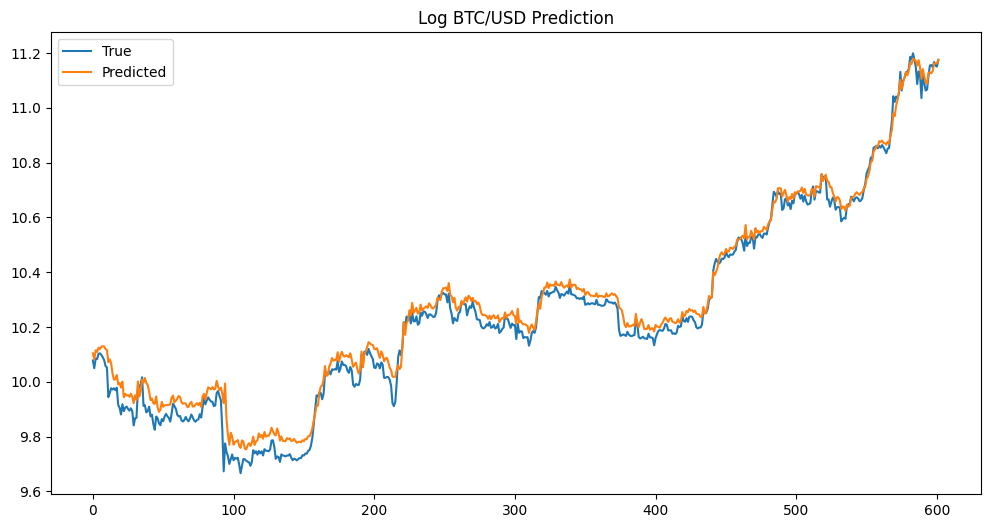

In [ ]:
# Graficamos predicciones contra valores reales

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('Log BTC/USD Prediction')
plt.legend()
plt.show()

In [ ]:
# Incorporamos Esquema de Inversión para ver Efecto de la Predicción en Objetivo de Negocio

# Convertimos log_price en niveles originales

y_test = y_test.ravel()
y_pred = y_pred.ravel()

mean = scaler.mean_[0]
scale = scaler.scale_[0]

y_test_prices = y_test * scale + mean
y_pred_prices = y_pred * scale + mean


# Calculamos cambios en precios predichos

price_changes = y_pred_prices[1:] - y_test_prices[:-1]

print("Dimensiones Price changes:", price_changes.shape)
print("Dimensión y_test_prices:", y_test_prices.shape)


# Generamos Señales de compra/venta

signals = np.where(price_changes > 0, 1, np.where(price_changes < 0, -1, 0))


# Validamos Dimensiones

print("Dimensión Signals:", signals.shape)
print("Muestra Signals:", signals[:10])


# Calculamos Retornos

initial_capital = 10000
capital = initial_capital
position = 0
for i, (signal, price) in enumerate(zip(signals, y_test_prices[1:])):
    if isinstance(signal, np.ndarray):
        signal = signal[0]  # Ensure signal is a scalar
    if signal == 1:  # Buy
        if capital > 0:
            position = capital / price
            capital = 0
    elif signal == -1:  # Sell
        if position > 0:
            capital = position * price
            position = 0
    print(f"Iteration {i}, Signal: {signal}, Price: {price}, Capital: {capital}, Position: {position}")

# Capital Final

if position > 0:
    capital = position * y_test_prices[-1]

print(f"Capital Inicial : ${initial_capital}")
print(f"Capital Final: ${capital:.2f}")


Dimensiones Price changes: (601,)
Dimensión y_test_prices: (602,)
Dimensión Signals: (601,)
Muestra Signals: [1 1 1 1 1 1 1 1 1 1]
Iteration 0, Signal: 1, Price: 186381.0624278266, Capital: 0, Position: 0.05365351967489914
Iteration 1, Signal: 1, Price: 186972.2585876067, Capital: 0, Position: 0.05365351967489914
Iteration 2, Signal: 1, Price: 186952.59825289506, Capital: 0, Position: 0.05365351967489914
Iteration 3, Signal: 1, Price: 187279.72614043008, Capital: 0, Position: 0.05365351967489914
Iteration 4, Signal: 1, Price: 187310.32384671364, Capital: 0, Position: 0.05365351967489914
Iteration 5, Signal: 1, Price: 187212.54029273585, Capital: 0, Position: 0.05365351967489914
Iteration 6, Signal: 1, Price: 187070.78809492747, Capital: 0, Position: 0.05365351967489914
Iteration 7, Signal: 1, Price: 186896.55608800813, Capital: 0, Position: 0.05365351967489914
Iteration 8, Signal: 1, Price: 186521.47576444218, Capital: 0, Position: 0.05365351967489914
Iteration 9, Signal: 1, Price: 186

# **APROXIMACIÓN 4 RNN**

In [ ]:
# Importamos Librerías Necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout

In [ ]:
# Cargamos información BTC/USD

df=pd.read_excel('/content/BitCoin_2016_202403_A.xlsx')

In [ ]:
# Transformamos formato 'Date'

df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# Ponemos 'Date' como Index y organizamos cronológicamente

df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

In [ ]:
# Incorporamos Transformación Logarítmica

df['Log_Price'] = np.log(df['Price'])

In [ ]:
# Creamos Rezagos

def create_lag_features(data, n_lags=2):
    lagged_data = data.copy()
    for lag in range(1, n_lags + 1):
        lagged_data[f'log_lag_{lag}'] = lagged_data['Log_Price'].shift(lag)
    return lagged_data

lagged_df = create_lag_features(df, n_lags=4)
lagged_df.dropna(inplace=True)

In [ ]:
# Dividimos en Train y Test

split_date = lagged_df.index[int(0.8 * len(lagged_df))]
train_df = lagged_df[lagged_df.index < split_date]
test_df = lagged_df[lagged_df.index >= split_date]

X_train = train_df.drop(columns=['Price', 'Log_Price'])
y_train = train_df['Log_Price']
X_test = test_df.drop(columns=['Price', 'Log_Price'])
y_test = test_df['Log_Price']

# Aseguramos compatibilidad de dimensiones

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [ ]:
X_train

,Open,High,Low,Vol.,Change %,log_lag_1,log_lag_2,log_lag_3,log_lag_4
Date,,,,,,,,,
2016-01-05,433.3,435.3,428.9,4503000.0,-0.49,6.071430,6.065412,6.072353,6.073045
2016-01-06,431.2,432.1,425.0,4343000.0,-0.09,6.066572,6.071430,6.065412,6.072353
2016-01-07,430.8,457.5,428.5,13020000.0,6.09,6.065644,6.066572,6.071430,6.065412
2016-01-08,457.0,462.9,446.5,9131000.0,-0.91,6.124683,6.065644,6.066572,6.071430
2016-01-09,452.9,454.5,444.9,3981000.0,-1.01,6.115671,6.124683,6.065644,6.066572
...,...,...,...,...,...,...,...,...,...
2022-08-03,22988.7,23623.7,22698.6,17466000.0,-0.73,10.042754,10.054972,10.056355,10.070450
2022-08-04,22822.2,23214.5,22438.7,18119000.0,-0.91,10.035428,10.042754,10.054972,10.056355
2022-08-05,22613.3,23447.6,22593.5,20890000.0,3.08,10.026240,10.035428,10.042754,10.054972


In [ ]:
# Escalamos Datos

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Redimensionamos para RNN

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Validamos Dimensiones

print(f"X_train_reshaped shape: {X_train_reshaped.shape}, y_train shape: {y_train.shape}")
print(f"X_test_reshaped shape: {X_test_reshaped.shape}, y_test shape: {y_test.shape}")


X_train_reshaped shape: (2407, 9, 1), y_train shape: (2407,)
X_test_reshaped shape: (602, 9, 1), y_test shape: (602,)


In [ ]:
# Creamos función para el modelo

def create_model(optimizer='adam', units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(SimpleRNN(units=units, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(SimpleRNN(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
# Establecemos Hiperparámetros para el Grid

param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'optimizer': ['adam', 'rmsprop'],
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3]
}


In [ ]:
# Establecemos Validación Cruzada para Serie de Tiempo

tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
# Implementamos el Grid Search

best_score = float('inf')
best_params = {}
for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for optimizer in param_grid['optimizer']:
            for units in param_grid['units']:
                for dropout_rate in param_grid['dropout_rate']:
                    for train_index, val_index in tscv.split(X_train_reshaped):
                        X_train_fold, X_val_fold = X_train_reshaped[train_index], X_train_reshaped[val_index]
                        y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]

                        # Create and train model
                        model = create_model(optimizer=optimizer, units=units, dropout_rate=dropout_rate)
                        model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=0)

                        # Validate model
                        y_val_pred = model.predict(X_val_fold)
                        score = mean_squared_error(y_val_fold, y_val_pred)

                        # Track best parameters
                        if score < best_score:
                            best_score = score
                            best_params = {
                                'batch_size': batch_size,
                                'epochs': epochs,
                                'optimizer': optimizer,
                                'units': units,
                                'dropout_rate': dropout_rate
                            }

# Mostramos mejores valores y Métrica

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")


19/19 [==============================] - 0s 3ms/step
Best parameters: {'batch_size': 32, 'epochs': 20, 'optimizer': 'adam', 'units': 100, 'dropout_rate': 0.2}
Best score: 0.0064724052842584055


In [ ]:
# Entrenamos mejor modelo con todo conjunto de entrenamiento

best_model = create_model(optimizer=best_params['optimizer'], units=best_params['units'], dropout_rate=best_params['dropout_rate'])
best_model.fit(X_train_reshaped, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)


In [ ]:
# Evaluamos modelo en Test

y_pred = best_model.predict(X_test_reshaped)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

19/19 [==============================] - 0s 3ms/step
Test RMSE: 0.1097298390024833


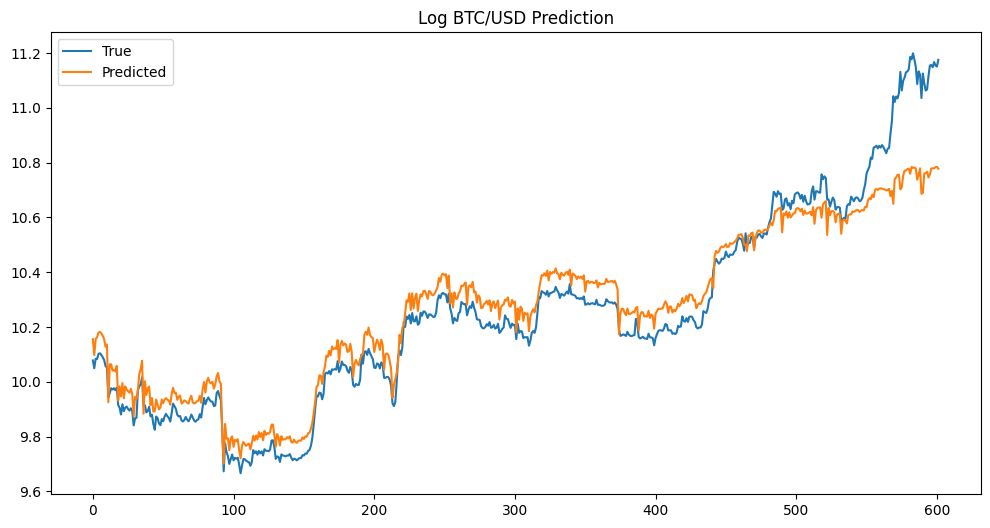

In [ ]:
# Graficamos predicciones y valores reales

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('Log BTC/USD Prediction')
plt.legend()
plt.show()

In [ ]:
# Incorporamos Esquema de Inversión para ver Efecto de la Predicción en Objetivo de Negocio

# Convertimos log_price en niveles originales

y_test = y_test.ravel()
y_pred = y_pred.ravel()

mean = scaler.mean_[0]
scale = scaler.scale_[0]

y_test_prices = y_test * scale + mean
y_pred_prices = y_pred * scale + mean


# Calculamos cambios en precios predichos

price_changes = y_pred_prices[1:] - y_test_prices[:-1]

print("Dimensiones Price changes:", price_changes.shape)
print("Dimensión y_test_prices:", y_test_prices.shape)


# Generamos Señales de compra/venta

signals = np.where(price_changes > 0, 1, np.where(price_changes < 0, -1, 0))


# Validamos Dimensiones

print("Dimensión Signals:", signals.shape)
print("Muestra Signals:", signals[:10])


# Calculamos Retornos

initial_capital = 10000
capital = initial_capital
position = 0
for i, (signal, price) in enumerate(zip(signals, y_test_prices[1:])):
    if isinstance(signal, np.ndarray):
        signal = signal[0]  # Ensure signal is a scalar
    if signal == 1:  # Buy
        if capital > 0:
            position = capital / price
            capital = 0
    elif signal == -1:  # Sell
        if position > 0:
            capital = position * price
            position = 0
    print(f"Iteration {i}, Signal: {signal}, Price: {price}, Capital: {capital}, Position: {position}")

# Capital Final

if position > 0:
    capital = position * y_test_prices[-1]

print(f"Capital Inicial : ${initial_capital}")
print(f"Capital Final: ${capital:.2f}")


Dimensiones Price changes: (601,)
Dimensión y_test_prices: (602,)
Dimensión Signals: (601,)
Muestra Signals: [1 1 1 1 1 1 1 1 1 1]
Iteration 0, Signal: 1, Price: 186381.0624278266, Capital: 0, Position: 0.05365351967489914
Iteration 1, Signal: 1, Price: 186972.2585876067, Capital: 0, Position: 0.05365351967489914
Iteration 2, Signal: 1, Price: 186952.59825289506, Capital: 0, Position: 0.05365351967489914
Iteration 3, Signal: 1, Price: 187279.72614043008, Capital: 0, Position: 0.05365351967489914
Iteration 4, Signal: 1, Price: 187310.32384671364, Capital: 0, Position: 0.05365351967489914
Iteration 5, Signal: 1, Price: 187212.54029273585, Capital: 0, Position: 0.05365351967489914
Iteration 6, Signal: 1, Price: 187070.78809492747, Capital: 0, Position: 0.05365351967489914
Iteration 7, Signal: 1, Price: 186896.55608800813, Capital: 0, Position: 0.05365351967489914
Iteration 8, Signal: 1, Price: 186521.47576444218, Capital: 0, Position: 0.05365351967489914
Iteration 9, Signal: 1, Price: 186

In [ ]:
# Capital Final

if position > 0:
    capital = position * y_test_prices[-1]

print(f"Capital Inicial : ${initial_capital}")
print(f"Capital Final: ${capital:.2f}")


Capital Inicial : $10000
Capital Final: $10392.78


# **APROXIMACIÓN 5 MLP**

In [ ]:
# Importamos Librerías Necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [ ]:
# Cargamos Base

df = pd.read_excel('/content/BitCoin_2016_202403_A.xlsx')


In [ ]:
# Transformamos formato 'Date'

df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# Establecemos 'Date' como Index y Ordenamos Cronológicamente

df.set_index('Date', inplace=True)
df.sort_index(inplace=True)


In [ ]:
# Implementamos transformación logarítmica

df['Log_Price'] = np.log(df['Price'])

In [ ]:
# Creamos rezagos

def create_lag_features(data, n_lags=2):
    lagged_data = data.copy()
    for lag in range(1, n_lags + 1):
        lagged_data[f'log_lag_{lag}'] = lagged_data['Log_Price'].shift(lag)
    return lagged_data

lagged_df = create_lag_features(df, n_lags=4)
lagged_df.dropna(inplace=True)

In [ ]:
# Dividimos entrenamiento y Test

split_date = lagged_df.index[int(0.8 * len(lagged_df))]
train_df = lagged_df[lagged_df.index < split_date]
test_df = lagged_df[lagged_df.index >= split_date]

X_train = train_df.drop(columns=['Price', 'Log_Price'])
y_train = train_df['Log_Price']
X_test = test_df.drop(columns=['Price', 'Log_Price'])
y_test = test_df['Log_Price']

In [ ]:
# Validamos dimensiones

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [ ]:
X_train

,Open,High,Low,Vol.,Change %,log_lag_1,log_lag_2,log_lag_3,log_lag_4
Date,,,,,,,,,
2016-01-05,433.3,435.3,428.9,4503000.0,-0.49,6.071430,6.065412,6.072353,6.073045
2016-01-06,431.2,432.1,425.0,4343000.0,-0.09,6.066572,6.071430,6.065412,6.072353
2016-01-07,430.8,457.5,428.5,13020000.0,6.09,6.065644,6.066572,6.071430,6.065412
2016-01-08,457.0,462.9,446.5,9131000.0,-0.91,6.124683,6.065644,6.066572,6.071430
2016-01-09,452.9,454.5,444.9,3981000.0,-1.01,6.115671,6.124683,6.065644,6.066572
...,...,...,...,...,...,...,...,...,...
2022-08-03,22988.7,23623.7,22698.6,17466000.0,-0.73,10.042754,10.054972,10.056355,10.070450
2022-08-04,22822.2,23214.5,22438.7,18119000.0,-0.91,10.035428,10.042754,10.054972,10.056355
2022-08-05,22613.3,23447.6,22593.5,20890000.0,3.08,10.026240,10.035428,10.042754,10.054972


In [ ]:
# Escalamos

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# En este caso no necesitamos transformación

X_train_reshaped = X_train_scaled
X_test_reshaped = X_test_scaled

# Validamos Dimensiones

print(f"X_train_reshaped shape: {X_train_reshaped.shape}, y_train shape: {y_train.shape}")
print(f"X_test_reshaped shape: {X_test_reshaped.shape}, y_test shape: {y_test.shape}")


X_train_reshaped shape: (2407, 9), y_train shape: (2407,)
X_test_reshaped shape: (602, 9), y_test shape: (602,)


In [ ]:
# Creamos función del modelo

def create_model(optimizer='adam', units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(units=units, activation='relu', input_shape=(X_train_reshaped.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
# Establecemos hiperparámetros para grid

param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'optimizer': ['adam', 'rmsprop'],
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3]
}


In [ ]:
# Validación Cruzada para Serie de Tiempo

tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
# Implementamos Grid Search

best_score = float('inf')
best_params = {}
for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for optimizer in param_grid['optimizer']:
            for units in param_grid['units']:
                for dropout_rate in param_grid['dropout_rate']:
                    for train_index, val_index in tscv.split(X_train_reshaped):
                        X_train_fold, X_val_fold = X_train_reshaped[train_index], X_train_reshaped[val_index]
                        y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]


                        model = create_model(optimizer=optimizer, units=units, dropout_rate=dropout_rate)
                        model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=0)


                        y_val_pred = model.predict(X_val_fold)
                        score = mean_squared_error(y_val_fold, y_val_pred)


                        if score < best_score:
                            best_score = score
                            best_params = {
                                'batch_size': batch_size,
                                'epochs': epochs,
                                'optimizer': optimizer,
                                'units': units,
                                'dropout_rate': dropout_rate
                            }

# Mostramos mejores parámetros y métrica

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")


19/19 [==============================] - 0s 2ms/step
Best parameters: {'batch_size': 16, 'epochs': 20, 'optimizer': 'rmsprop', 'units': 100, 'dropout_rate': 0.3}
Best score: 0.022588280354934664


In [ ]:
# Entrenamos mejor modelo sobre todo conjunto de Train

best_model = create_model(optimizer=best_params['optimizer'], units=best_params['units'], dropout_rate=best_params['dropout_rate'])
best_model.fit(X_train_reshaped, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)


In [ ]:
# Evaluamos modelo sobre test

y_pred = best_model.predict(X_test_reshaped)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

19/19 [==============================] - 0s 2ms/step
Test RMSE: 0.370237664422321


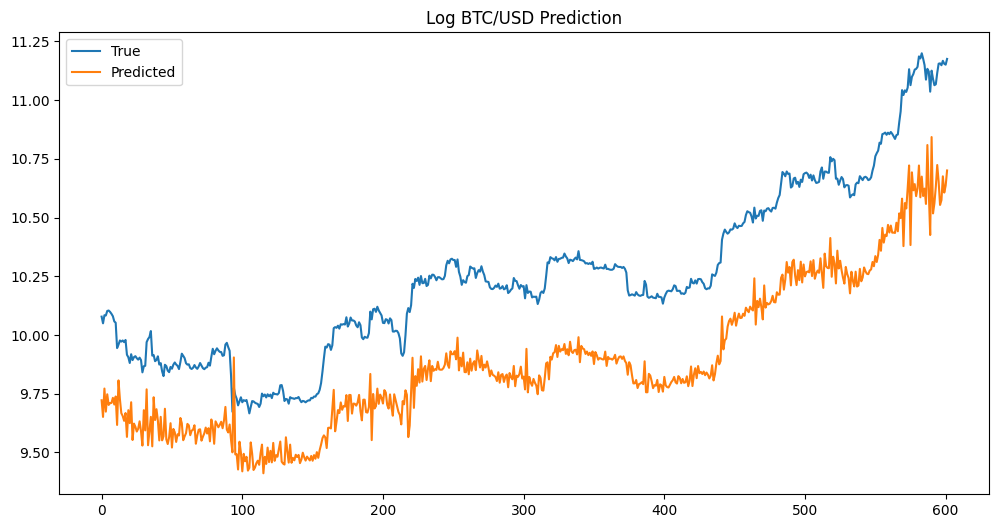

In [ ]:
# Graficamos predicciones y valores reales

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('Log BTC/USD Prediction')
plt.legend()
plt.show()

In [ ]:
# Incorporamos Esquema de Inversión para ver Efecto de la Predicción en Objetivo de Negocio

# Convertimos log_price en niveles originales

y_test = y_test.ravel()
y_pred = y_pred.ravel()

mean = scaler.mean_[0]
scale = scaler.scale_[0]

y_test_prices = y_test * scale + mean
y_pred_prices = y_pred * scale + mean


# Calculamos cambios en precios predichos

price_changes = y_pred_prices[1:] - y_test_prices[:-1]

print("Dimensiones Price changes:", price_changes.shape)
print("Dimensión y_test_prices:", y_test_prices.shape)


# Generamos Señales de compra/venta

signals = np.where(price_changes > 0, 1, np.where(price_changes < 0, -1, 0))


# Validamos Dimensiones

print("Dimensión Signals:", signals.shape)
print("Muestra Signals:", signals[:10])


# Calculamos Retornos

initial_capital = 10000
capital = initial_capital
position = 0
for i, (signal, price) in enumerate(zip(signals, y_test_prices[1:])):
    if isinstance(signal, np.ndarray):
        signal = signal[0]  # Ensure signal is a scalar
    if signal == 1:  # Buy
        if capital > 0:
            position = capital / price
            capital = 0
    elif signal == -1:  # Sell
        if position > 0:
            capital = position * price
            position = 0
    print(f"Iteration {i}, Signal: {signal}, Price: {price}, Capital: {capital}, Position: {position}")

# Capital Final

if position > 0:
    capital = position * y_test_prices[-1]

print(f"Capital Inicial : ${initial_capital}")
print(f"Capital Final: ${capital:.2f}")


Dimensiones Price changes: (601,)
Dimensión y_test_prices: (602,)
Dimensión Signals: (601,)
Muestra Signals: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Iteration 0, Signal: -1, Price: 186381.0624278266, Capital: 10000, Position: 0
Iteration 1, Signal: -1, Price: 186972.2585876067, Capital: 10000, Position: 0
Iteration 2, Signal: -1, Price: 186952.59825289506, Capital: 10000, Position: 0
Iteration 3, Signal: -1, Price: 187279.72614043008, Capital: 10000, Position: 0
Iteration 4, Signal: -1, Price: 187310.32384671364, Capital: 10000, Position: 0
Iteration 5, Signal: -1, Price: 187212.54029273585, Capital: 10000, Position: 0
Iteration 6, Signal: -1, Price: 187070.78809492747, Capital: 10000, Position: 0
Iteration 7, Signal: -1, Price: 186896.55608800813, Capital: 10000, Position: 0
Iteration 8, Signal: -1, Price: 186521.47576444218, Capital: 10000, Position: 0
Iteration 9, Signal: -1, Price: 186422.94765790104, Capital: 10000, Position: 0
Iteration 10, Signal: -1, Price: 184583.04753776858, Capital:

# **APROXIMACIÓN 6 LSTM CON INDICADORES DE ANÁLISIS TÉCNICO**

In [ ]:
# Importamos TA-Lib

!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=5f518ea6ad1420f59be1d97e710409da61ceb7598ceaf1184b2b437f1098e245
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
# Importamos Librerías Necesarias

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import ta
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import KFold
from itertools import product

In [ ]:
# Cargamos datos

df = pd.read_excel('/content/BitCoin_2016_202403_A.xlsx')

In [ ]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,03/31/2024,71332.0,69608.5,71367.5,69576.6,4245000.0,2.47
1,03/30/2024,69611.5,69872.3,70321.2,69564.9,2987000.0,-0.37
2,03/29/2024,69871.7,70766.7,70907.0,69090.9,5899000.0,-1.26
3,03/28/2024,70762.1,69449.4,71542.5,68956.9,7249000.0,1.90
4,03/27/2024,69442.4,69999.2,71670.8,68428.6,11288000.0,-0.80
...,...,...,...,...,...,...,...
3008,01/05/2016,431.2,433.3,435.3,428.9,4503000.0,-0.49
3009,01/04/2016,433.3,430.7,435.3,428.6,5301000.0,0.61
3010,01/03/2016,430.7,433.7,434.1,423.1,5483000.0,-0.70
3011,01/02/2016,433.7,434.0,437.4,430.7,3357000.0,-0.06


In [ ]:
# Transformamos formato de 'Date'

df['Date']=pd.to_datetime(df['Date'])

In [ ]:
# Ponemos fecha como Index

df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

In [ ]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2016-01-01,434.0,430.0,438.0,425.9,4697000.0,0.94
2016-01-02,433.7,434.0,437.4,430.7,3357000.0,-0.06
2016-01-03,430.7,433.7,434.1,423.1,5483000.0,-0.70
2016-01-04,433.3,430.7,435.3,428.6,5301000.0,0.61
2016-01-05,431.2,433.3,435.3,428.9,4503000.0,-0.49
...,...,...,...,...,...,...
2024-03-27,69442.4,69999.2,71670.8,68428.6,11288000.0,-0.80
2024-03-28,70762.1,69449.4,71542.5,68956.9,7249000.0,1.90
2024-03-29,69871.7,70766.7,70907.0,69090.9,5899000.0,-1.26


In [ ]:
# Calculamos Indicadores Técnicos

df['SMA'] = ta.trend.sma_indicator(df['Price'], window=14)
df['EMA'] = ta.trend.ema_indicator(df['Price'], window=14)
df['RSI'] = ta.momentum.rsi(df['Price'], window=14)
macd = ta.trend.MACD(df['Price'])
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()
df['MACD_hist'] = macd.macd_diff()

In [ ]:
# Inputamos Valores NaN

df.fillna(method='bfill', inplace=True)

In [ ]:
# Implementamos Transformación Logarítmica

df['Log_Price'] = np.log(df['Price'])

In [ ]:
# Escalamos los Datos

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Log_Price', 'SMA', 'EMA', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist']])

In [ ]:
# Creamos Rezagos

def create_lagged_features(data, lag=4):
    features = []
    for i in range(lag, len(data)):
        features.append(data[i-lag:i, :])
    return np.array(features)

In [ ]:
# Creamos Variable Objetivo

target = scaled_data[4:, 0]

In [ ]:
target

array([0.02995424, 0.02977884, 0.04093722, ..., 0.99155052, 0.99084538,
       0.99545983])

In [ ]:
# Preparamos datos para LSTM

X = create_lagged_features(scaled_data)
y = target

In [ ]:
# Dividimos en Entrenamiento y Test

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
X_train

array([[[0.03117754, 0.00090871, 0.00085679, ..., 0.47847155,
         0.46524248, 0.56917394],
        [0.03104685, 0.00090871, 0.00085679, ..., 0.47847155,
         0.46524248, 0.56917394],
        [0.02973496, 0.00090871, 0.00085679, ..., 0.47847155,
         0.46524248, 0.56917394],
        [0.03087246, 0.00090871, 0.00085679, ..., 0.47847155,
         0.46524248, 0.56917394]],

       [[0.03104685, 0.00090871, 0.00085679, ..., 0.47847155,
         0.46524248, 0.56917394],
        [0.02973496, 0.00090871, 0.00085679, ..., 0.47847155,
         0.46524248, 0.56917394],
        [0.03087246, 0.00090871, 0.00085679, ..., 0.47847155,
         0.46524248, 0.56917394],
        [0.02995424, 0.00090871, 0.00085679, ..., 0.47847155,
         0.46524248, 0.56917394]],

       [[0.02973496, 0.00090871, 0.00085679, ..., 0.47847155,
         0.46524248, 0.56917394],
        [0.03087246, 0.00090871, 0.00085679, ..., 0.47847155,
         0.46524248, 0.56917394],
        [0.02995424, 0.00090871, 0.0

In [ ]:
y_train

array([0.02995424, 0.02977884, 0.04093722, ..., 0.78405718, 0.78108233,
       0.78297645])

In [ ]:
# Definimos el Modelo

def create_model(units=50, dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [ ]:
# Definimos Parámetros Grid

param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'optimizer': ['adam', 'rmsprop'],
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3]
}

In [ ]:
# Implementamos Grid Search

best_score = float('inf')
best_params = None
kf = KFold(n_splits=5)

for batch_size, epochs, optimizer, units, dropout_rate in product(
        param_grid['batch_size'], param_grid['epochs'], param_grid['optimizer'],
        param_grid['units'], param_grid['dropout_rate']):

    fold_scores = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model = create_model(units=units, dropout_rate=dropout_rate, optimizer=optimizer)
        model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=0)

        y_val_pred = model.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
        fold_scores.append(rmse)

    avg_rmse = np.mean(fold_scores)

    if avg_rmse < best_score:
        best_score = avg_rmse
        best_params = {'batch_size': batch_size, 'epochs': epochs, 'optimizer': optimizer, 'units': units, 'dropout_rate': dropout_rate}

print(f"Best RMSE: {best_score} using {best_params}")

16/16 [==============================] - 1s 2ms/step
Best RMSE: 0.013683220122742817 using {'batch_size': 32, 'epochs': 20, 'optimizer': 'adam', 'units': 100, 'dropout_rate': 0.2}


In [ ]:
# Entrenamos mejor modelo sobre Train

best_model = create_model(optimizer=best_params['optimizer'], units=best_params['units'], dropout_rate=best_params['dropout_rate'])
best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [ ]:
# Evaluamos Modelo en Test

y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

19/19 [==============================] - 1s 3ms/step
Test RMSE: 0.013727750496390358


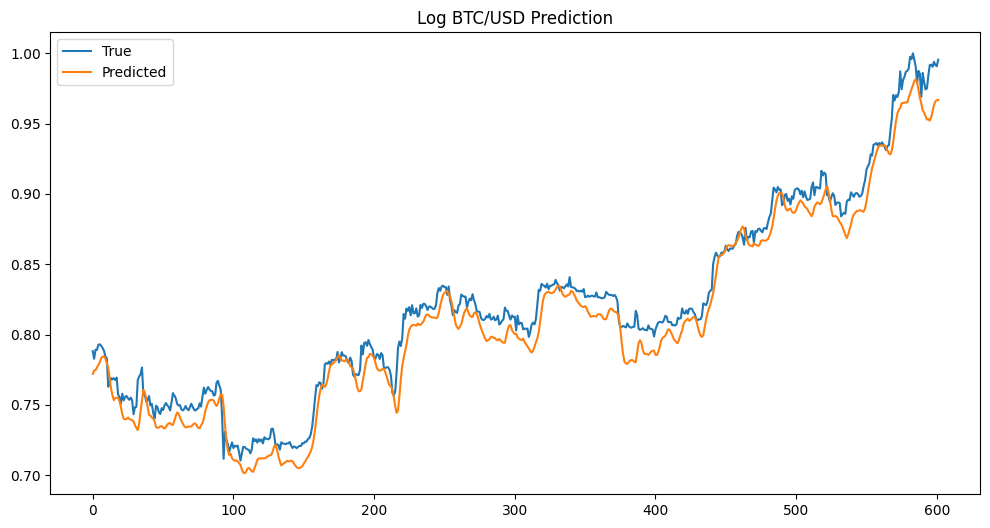

In [ ]:
# Graficamos Predicciones y Valor Real

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('Log BTC/USD Prediction')
plt.legend()
plt.show()

In [ ]:
# Convertimos log_price en niveles originales

y_test_prices = np.exp(y_test * scaler.data_range_[0] + scaler.data_min_[0])
y_pred_prices = np.exp(y_pred * scaler.data_range_[0] + scaler.data_min_[0])

In [ ]:
# Calculamos cambios en precios predichos

price_changes = y_pred_prices[1:] - y_test_prices[:-1]

print("Dimensiones Price changes:", price_changes.shape)
print("Dimensión y_test_prices:", y_test_prices.shape)

Dimensiones Price changes: (601, 601)
Dimensión y_test_prices: (602,)


In [ ]:
# Generamos Señales de compra/venta

signals = np.where(price_changes > 0, 1, np.where(price_changes < 0, -1, 0))

In [ ]:
# Validamos Dimensiones

print("Dimensión Signals:", signals.shape)
print("Muestra Signals:", signals[:10])


Dimensión Signals: (601, 601)
Muestra Signals: [[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1  1 -1 ... -1 -1 -1]
 [-1  1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


In [ ]:
# Calculamos Retornos

initial_capital = 10000
capital = initial_capital
position = 0
for i, (signal, price) in enumerate(zip(signals, y_test_prices[1:])):
    if isinstance(signal, np.ndarray):
        signal = signal[0]  # Ensure signal is a scalar
    if signal == 1:  # Buy
        if capital > 0:
            position = capital / price
            capital = 0
    elif signal == -1:  # Sell
        if position > 0:
            capital = position * price
            position = 0
    print(f"Iteration {i}, Signal: {signal}, Price: {price}, Capital: {capital}, Position: {position}")

Iteration 0, Signal: -1, Price: 23146.699999999993, Capital: 10000, Position: 0
Iteration 1, Signal: -1, Price: 23962.900000000005, Capital: 10000, Position: 0
Iteration 2, Signal: -1, Price: 23935.300000000003, Capital: 10000, Position: 0
Iteration 3, Signal: -1, Price: 24398.699999999986, Capital: 10000, Position: 0
Iteration 4, Signal: -1, Price: 24442.500000000004, Capital: 10000, Position: 0
Iteration 5, Signal: -1, Price: 24302.799999999996, Capital: 10000, Position: 0
Iteration 6, Signal: -1, Price: 24101.699999999986, Capital: 10000, Position: 0
Iteration 7, Signal: -1, Price: 23856.79999999999, Capital: 10000, Position: 0
Iteration 8, Signal: -1, Price: 23337.99999999999, Capital: 10000, Position: 0
Iteration 9, Signal: -1, Price: 23203.599999999984, Capital: 10000, Position: 0
Iteration 10, Signal: -1, Price: 20831.300000000014, Capital: 10000, Position: 0
Iteration 11, Signal: -1, Price: 21138.900000000016, Capital: 10000, Position: 0
Iteration 12, Signal: -1, Price: 21517.2

In [ ]:
# Capital Final

if position > 0:
    capital = position * y_test_prices[-1]

print(f"Capital Inicial : ${initial_capital}")
print(f"Capital Final: ${capital:.2f}")

Capital Inicial : $10000
Capital Final: $24840.19
